# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [2]:
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/music_dataset.csv

--2023-06-07 13:31:56--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/music_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1321738 (1.3M) [text/plain]
Saving to: ‘music_dataset.csv’

music_dataset.csv   100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2023-06-07 13:31:57 (19.8 MB/s) - ‘music_dataset.csv’ saved [1321738/1321738]



In [3]:
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/tracks_info.csv

--2023-06-07 13:31:57--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/tracks_info.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3416170 (3.3M) [text/plain]
Saving to: ‘tracks_info.csv’

tracks_info.csv     100%[===================>]   3.26M  --.-KB/s    in 0.08s   

2023-06-07 13:31:57 (41.3 MB/s) - ‘tracks_info.csv’ saved [3416170/3416170]



In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

import math
import random

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    apk = []
    for r, p in zip(relevant, predicted):
        if len(p) > k:
            p = p[:k]
        
        score = 0.0
        true_positives = 0.0

        for i, pred in enumerate(p):
            if pred in r and pred not in p[:i]:
                true_positives += 1.0
                score += true_positives / (i+1.0)
                
                
        apk.append(score / min(len(r), k))
    return np.mean(apk)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]
assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant.append(user_data['trackId'].tolist())
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame, similarity_func):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = np.array(preds[user_id])
            new_preds[user_id] = user_preds[~np.in1d(np.array(user_preds), user_data['trackId'].array)][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id, user_data in tqdm(self.ratings.groupby('userId')):
            u2u = User2User(self.ratings, self.similarity_func)
            user_preds = sorted(zip(np.arange(self.n_items), u2u.similarity(user_data['trackId'].array)), key=lambda x: x[1], reverse=True)
            test_preds.append(list(dict(user_preds).keys()))
        self.predictions_full = test_preds
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    uppers = np.zeros(len(ratings.groupby('userId')))
    bottoms = np.zeros(len(ratings.groupby('userId')))
    user_len = len(user_vector)
    for user_id, user_data in ratings.groupby('userId'):
        """
        since we don't have any rating: just 0/1, we can simplify our function:
        - both r_ui and r_vi for an intersection are equal to 1, so upper is just length of intersection
        - same about r_ui^2 and r_vi^2, so each root is just summary of items for each user
        """
        uppers[user_id] = len(np.intersect1d(user_data['trackId'].array, user_vector))
        bottoms[user_id] = math.sqrt(user_len) * math.sqrt(len(user_data['trackId'].array))
    return uppers / bottoms
        



def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersections = np.zeros(len(ratings.groupby('userId')))
    unions = np.zeros(len(ratings.groupby('userId')))
    for user_id, user_data in ratings.groupby('userId'):
        intersections[user_id] = len(np.intersect1d(user_data['trackId'].array, user_vector))
        unions[user_id] = len(np.union1d(user_data['trackId'].array, user_vector))
    return intersections / unions

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [16]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)

        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        similar_users = self.similarity_func(self.ratings, user_vector)
        neighbours = np.where(similar_users > self.alpha)[0]
        tracks = np.zeros(self.n_items)
        for neighbour in neighbours:
            neighbour_tracks = np.where(self.R[neighbour] != 0)[0]
            # tracks[neighbour_tracks] += (similar_users[neighbour] / len(neighbour_tracks))
            tracks[neighbour_tracks] += similar_users[neighbour]
        tracks = tracks / similar_users.sum()
        return tracks

        

    def recommend(self, uid: int):
        return self.predictions_full[uid]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [20]:
model_pear = BaseModel(train_ratings, pearson)

In [21]:
dict_mapk_pear = {}
for k in tqdm(range(1, 30)):
    test_relevant_k = []
    if k == 1:
        preds_one = model_pear.get_test_recommendations(k)
        preds_pear = model_pear.predictions_full
        for rel in test_relevant:
            if len(rel) >= k:
                test_relevant_k.append(rel[:k])
            else:
                test_relevant_k.append(rel)
        dict_mapk_pear[k] = mapk(test_relevant_k, preds_one)
    else:
        for rel in test_relevant:
            if len(rel) >= k:
                test_relevant_k.append(rel[:k])
            else:
                test_relevant_k.append(rel)
        preds_now = model_pear.remove_train_items(preds_pear, k)
        dict_mapk_pear[k] = mapk(test_relevant_k, preds_now)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

In [22]:
model_jacc = BaseModel(train_ratings, jaccard)

In [23]:
dict_mapk_jacc = {}
for k in tqdm(range(1, 30)):
    test_relevant_k = []
    if k == 1:
        preds_one = model_jacc.get_test_recommendations(k)
        preds_jacc = model_jacc.predictions_full
        for rel in test_relevant:
            if len(rel) >= k:
                test_relevant_k.append(rel[:k])
            else:
                test_relevant_k.append(rel)
        dict_mapk_jacc[k] = mapk(test_relevant_k, preds_one)
    else:
        for rel in test_relevant:
            if len(rel) >= k:
                test_relevant_k.append(rel[:k])
            else:
                test_relevant_k.append(rel)
        preds_now = model_jacc.remove_train_items(preds_jacc, k)
        dict_mapk_jacc[k] = mapk(test_relevant_k, preds_now)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

In [24]:
random_50 = []
dict_mapk_rand = dict()

for k in tqdm(range(1, 30)):
    test_relevant_k = []
    random_k = []
    if k == 1:
        all_tracks = np.arange(model_pear.n_items)
        for _ in range(model_pear.n_users):
            user_50 = []
            for _ in range(50):
                track = random.choice(all_tracks)
                user_1 = [track]
                while track in user_50:
                    track = random.choice(all_tracks)
                user_50.append(track)
            random_50.append(user_50)
            random_k.append(user_1)
    else:
        for us in range(model_pear.n_users):
            random_k.append(random_50[us][:k])
    for rel in test_relevant:
        if len(rel) >= k:
            test_relevant_k.append(rel[:k])
        else:
            test_relevant_k.append(rel)
    dict_mapk_rand[k] = mapk(test_relevant_k, random_k)

  0%|          | 0/29 [00:00<?, ?it/s]

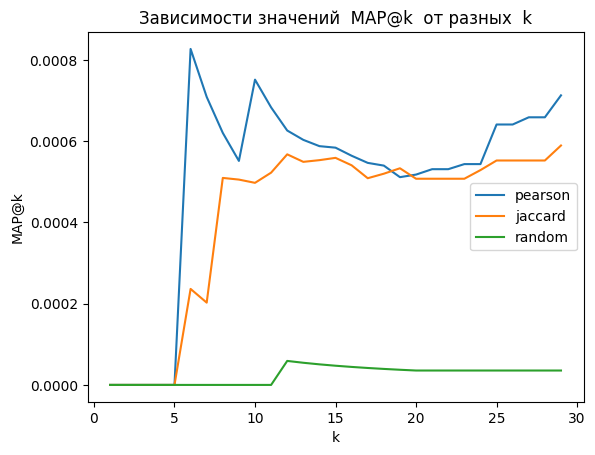

In [25]:
plt.plot(dict_mapk_pear.keys(), dict_mapk_pear.values(), label='pearson')
plt.plot(dict_mapk_jacc.keys(), dict_mapk_jacc.values(), label='jaccard')
plt.plot(dict_mapk_rand.keys(), dict_mapk_rand.values(), label='random')
plt.title('Зависимости значений  MAP@k  от разных  k')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

**ВЫВОДЫ**: Пирсон чуть лучше Жаккара, они оба лучше рандома, но качество, если честно, не особо.

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [26]:
rat = np.zeros((len(ratings.groupby('userId')), len(ratings.groupby('trackId'))))
rat[ratings['userId'], ratings['trackId']] = 1.

In [27]:
sparsity = float(len(rat.nonzero()[0]))
sparsity /= (rat.shape[0] * rat.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.81%


In [28]:
from scipy.sparse import csr_matrix
import scipy.sparse as sp

users = ratings["userId"]
movies = ratings["trackId"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [29]:
user_id = np.random.randint(0, model_pear.n_users)

In [30]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
10970,How Much Is The Fish?,['Scooter']
18870,Звёзды в лужах,['30.02']
23668,Дни Километры,['Nuteki']
24764,Roots,['Imagine Dragons']
26350,Смерть луны,['Asper X']
28622,"Детка, ты словно ламбо",['LUCAVEROS']
30578,Люби меня,"['Miyagi & Эндшпиль', 'Sимптом']"
30599,Санавабич,['Miyagi & Эндшпиль']
31292,Разрушительные сны,['Мимо Вселенной']
32668,It's Definitely You,"['V', 'Jin']"


In [31]:
preds = model_pear.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

  0%|          | 0/241 [00:00<?, ?it/s]

Predicted tracks:


,name,artists
59229,Мальчик на девятке,['DEAD BLONDE']
62418,Снова я напиваюсь,['SLAVA MARLOW']
59685,X.O,"['Andro', 'The Limba']"
37861,Я так соскучился,['Порнофильмы']
28807,Рапапам,"['9 грамм', 'Miyagi & Эндшпиль']"
2814,Numb,['Linkin Park']
24500,Way Down We Go,['KALEO']
53671,2 типа людей,['Макс Корж']
62003,СЛЁЗЫ,['Анет Сай']
54280,Комета,['JONY']


In [32]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
65285,Мама я музыкант,['Nikitata']
65305,Опять пропаду,['Скаттл']
65339,Белая ночь,"['Lvnx', 'Алина Селях']"
65375,Не грусти,"['NLO', 'Dan Korshunov']"
65380,Leck,"['MORGENSHTERN', 'Imanbek', 'Fetty Wap', 'KDDK']"
65393,Touch It,['Dj Viral TikToker']
65424,Save Your Tears,"['The Weeknd', 'Ariana Grande']"
65461,Не лей,['Bakr']
65483,Федерико Феллини,['Galibri & Mavik']
65502,ПОСЛЕДНЕЕ ЛЕТО ДЕТСТВА,['Nikitata']


**ВЫВОДЫ**: Получилось не супер, потому что рекомендации слишком общие (то есть чаще всего это просто достаточно популярные песни).

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L(Θ) = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:** 
$$
\nabla L(\Theta)=(\frac{\partial L}{\partial \theta_1}, \frac{\partial L}{\partial \theta_2}, ..., \frac{\partial L}{\partial \theta_n})^T
\\
\Theta=\{p_u,q_i| u\in U, i \in I\}
\\
\Theta_{t+1}=\Theta_t-\eta\nabla L(\Theta)
$$

Ответ
$$
p_{uk}:=p_{uk}+\eta q_{ik}(\langle p_u, q_u \rangle - r_{ui})
\\
q_{ik}:=q_{ik}+\eta p_{uk}(\langle p_u, q_u \rangle - r_{ui})
$$

**ALS:**
$$
\frac{1}{2}\frac{\partial L}{\partial P}=(R-PQ^T)Q+\lambda P=0 ⇒ P=RQ(Q^TQ+\lambda I)^{-1}
\\
\frac{1}{2}\frac{\partial L}{\partial Q}=P^T(R-PQ^T)+\lambda Q=0 ⇒ Q=R^TP(P^TP+\lambda I)^{-1}
$$
Итеративно фиксируем все параметры пользователей / объектов, чтобы оптимизировать параметры объектов / пользователей соответственно.<br>
Ответ:
$$
p_u^*(\Theta)=(Q^TQ+\lambda I)^{-1}r_uQ^T, \space \forall u\in U\space p^{2t+1}_u=p^*_u(\Theta_{2t})
\\
q_i^*(\Theta)=(P^TP+\lambda I)^{-1}r_iP^T, \space \forall i\in I\space q^{2t+2}_i=q^*_i(\Theta_{2t+1})
$$



**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [17]:
from sklearn.metrics import mean_squared_error
from copy import deepcopy

In [18]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return math.sqrt(mean_squared_error(prediction, ground_truth))

In [47]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', similarity_func=pearson, num_iters=5):
        super().__init__(ratings, similarity_func)
        self.dim = dim
        self.num_iters = num_iters
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(dim, self.n_users))
        self.Q = np.random.normal(size=(dim, self.n_items))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self):
        self.train_error = []
        users, items = self.R.nonzero()
        for epoch in tqdm(range(self.num_iters)):
            if self.mode == 'sgd':
                for u, i in zip(users, items):
                    error = self.R[u, i] - np.dot(self.P[:,u].T, self.Q[:,i])
                    self.P[:, u] += self.lr * (error * self.Q[:, i] - self.lamb * self.P[:, u])
                    self.Q[:, i] += self.lr * (error * self.P[:, u] - self.lamb * self.Q[:, i])
                train_rmse = rmse(np.dot(self.P.T, self.Q), self.R)
                self.train_error.append(train_rmse)

            elif self.mode == 'als':
                if epoch == 0:
                    self.P = self.P.T
                self.V = self.P @ self.Q
                error = deepcopy(self.V)
                error[np.unique(self.ratings['userId'].array).reshape(-1, 1), np.unique(self.ratings['trackId'].array)] -= self.R
                if epoch % 2 == 0:
                    self.P -= self.lr * (error @ self.Q.T + self.lamb * self.P)
                else:
                    self.Q -= self.lr * (self.P.T @ error + self.lamb * self.Q)
                r_hat = self.V[np.unique(self.ratings['userId'].array).reshape(-1, 1), np.unique(self.ratings['trackId'].array)]
                r_hat = np.nan_to_num(r_hat, 0)
                train_rmse = rmse(r_hat, self.R)
                self.train_error.append(train_rmse)
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.dim) * self.lamb
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

In [82]:
model = HiddenVars(train_ratings, num_iters=50, dim=32)

In [83]:
model.fit()

  0%|          | 0/50 [00:00<?, ?it/s]

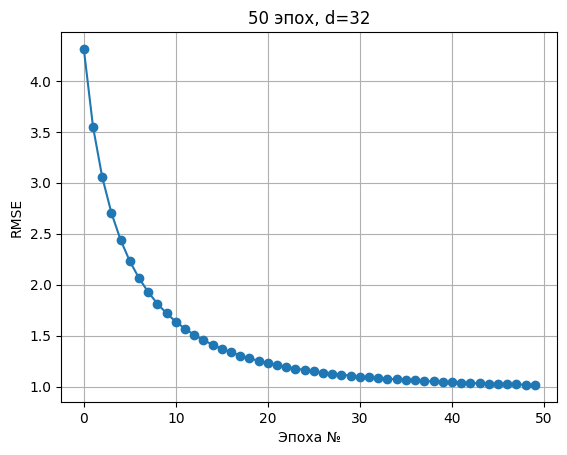

In [84]:
plt.plot(range(model.num_iters), model.train_error, marker='o')
plt.xlabel('Эпоха №')
plt.ylabel('RMSE')
plt.title('50 эпох, d=32')
plt.grid()
plt.show()

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

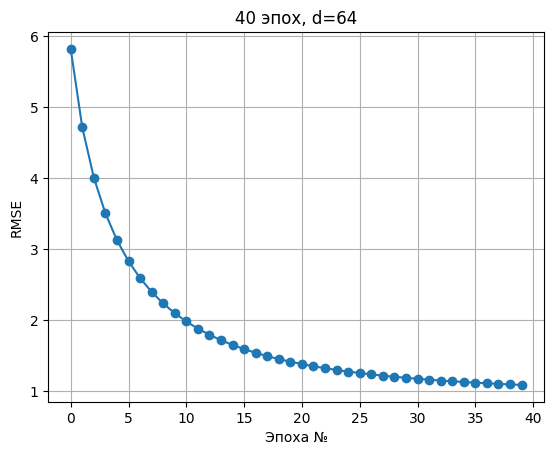

In [61]:
plt.plot(range(model.num_iters), model.train_error, marker='o')
plt.xlabel('Эпоха №')
plt.ylabel('RMSE')
plt.title('40 эпох, d=64')
plt.grid()
plt.show()

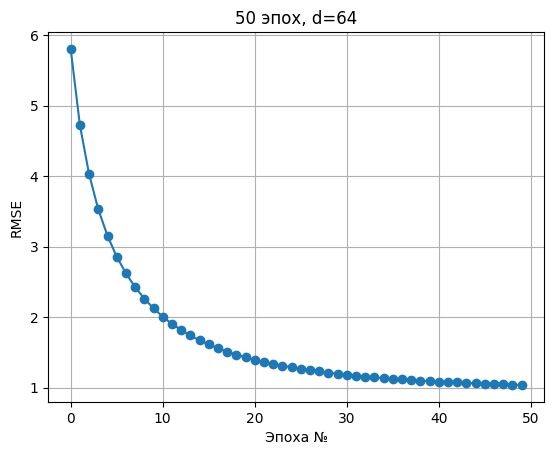

In [68]:
plt.plot(range(model.num_iters), model.train_error, marker='o')
plt.xlabel('Эпоха №')
plt.ylabel('RMSE')
plt.title('50 эпох, d=64')
plt.grid()
plt.show()

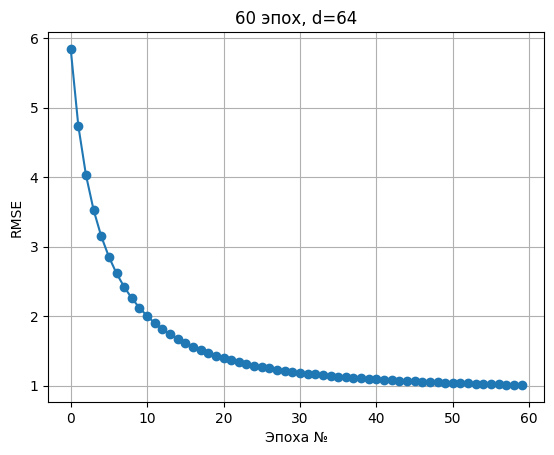

In [75]:
plt.plot(range(model.num_iters), model.train_error, marker='o')
plt.xlabel('Эпоха №')
plt.ylabel('RMSE')
plt.title('60 эпох, d=64')
plt.grid()
plt.show()

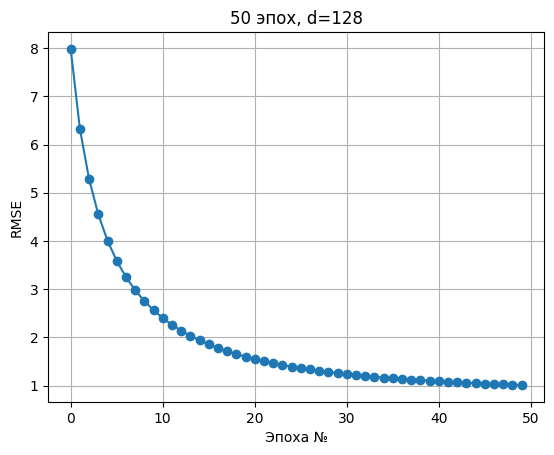

In [81]:
plt.plot(range(model.num_iters), model.train_error, marker='o')
plt.xlabel('Эпоха №')
plt.ylabel('RMSE')
plt.title('50 эпох, d=128')
plt.grid()
plt.show()

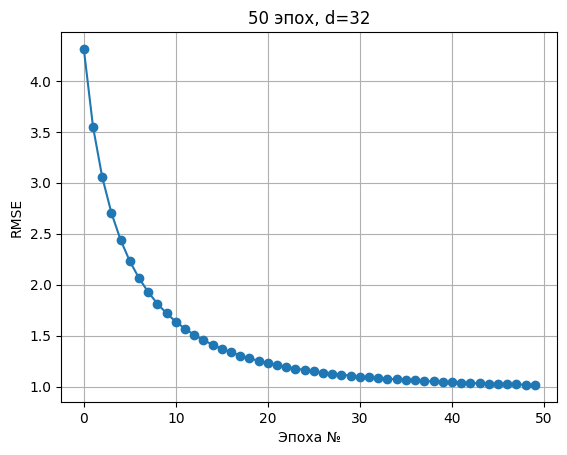

In [100]:
plt.plot(range(model.num_iters), model.train_error, marker='o')
plt.xlabel('Эпоха №')
plt.ylabel('RMSE')
plt.title('50 эпох, d=32')
plt.grid()
plt.show()

**ВЫВОДЫ**: Я посмотрела на параметры $d$ и $num\_iters$ при SGD. Самое лучшее качество схожих векторов песен получилось при $d=32$ и $num\_iters=50$.


Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [91]:
example_trackId = tracks_info[tracks_info.name == "Варвара"].iloc[0].id

preds = model.Q.T @ model.Q.T[example_trackId]
preds = preds / np.sqrt((model.Q.T**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [93]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q.T[example_trackId])
similar_tracks

,name,artists,similarity
5517,Варвара,['Би-2'],1.000000
20107,Anaconda,['Nicki Minaj'],0.655642
38468,Про червячков,['Егор Летов'],0.645976
55445,BLUD,['Sorta'],0.632782
17881,Баллада о борьбе,['Мельница'],0.622385
53726,Deserve to Love,['Anton Makarov'],0.614288
15441,Я так хочу...,['Океан Ельзи'],0.611727
50018,Зима,['Сегодняночью'],0.609224
17495,The Earth Prelude,['Ludovico Einaudi'],0.609031
15743,Time Stood Still,['Madonna'],0.606652
